# Vancouver Island

Evan Muise

# setup always run

Load Packages

In [ ]:
library(tidyverse)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

terra 1.7.78

Attaching package: 'terra'

The following object is masked from 'package:tidyr':

    extract

Linking to GEOS 3.12.1, GDAL 3.8.4, PROJ 9.3.1; sf_use_s2() is TRUE


Attaching package: 'glue'

The following object is masked from 'package:terra':

    trim


Attaching package: 'tidyterra'

The following object is masked from 'package:stats':

    filter


Attaching package: 'arrow'

The following object is masked from 'package:terra':

    buffer

The following object is masked from 'package:lubridate':

    duration

The following object is masked from 'package:utils':

    timestamp


Attaching package: 'patchwork'

The following object is masked from 'package:terra':

    area

Loading required package: future


Attaching package: 'data.table'

The following object is masked from 'package:terra':

    shift

The following objects are masked from 'package:lubridate':

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year

The following objects are masked from 'package:dplyr':

    between, first, last

The following object is masked from 'package:purrr':

    transpose

Set up folder structure

In [ ]:
base_data_loc <- here::here("strathcona")
dir.create(base_data_loc, showWarnings = F)

input_loc <- here::here("data", "rasters", "inputs")
dir.create(input_loc, showWarnings = F)
tab_loc <- here::here(base_data_loc, "data", "tabs")
dir.create(tab_loc, showWarnings = F, recursive = T)

scratch <- here::here("data", "scratch")
dir.create(scratch, showWarnings = F)

split_loc <- here::here(tab_loc, "split_strata")
dir.create(split_loc, showWarnings = F)

treat_loc <- here::here(tab_loc, "treatment_strata")
dir.create(treat_loc, showWarnings = F)

mahal_tab_loc <- here::here(tab_loc, "mahal")
dir.create(mahal_tab_loc, showWarnings = F)

mahal_ras_loc <- here::here(base_data_loc, "data", "rasters", "mahal")
dir.create(mahal_ras_loc, showWarnings = F, recursive = T)

nn_save_loc <- here::here(base_data_loc, "data", "rasters", "nn_dist")
dir.create(nn_save_loc, showWarnings = F)

shapefile_loc <- here::here(base_data_loc, "data", "shapefiles")
dir.create(shapefile_loc, showWarnings = F)

figure_loc <- here::here(base_data_loc, "figures")
dir.create(figure_loc, showWarnings = F)

Map and plot themes

In [ ]:
map_theme <- theme_grey() + 
  theme(panel.background = element_rect(fill = "white", colour = "black"),
    panel.grid = element_line(colour = "#ebebeb"),
    legend.position = "inside",
    legend.position.inside = c(0.8, 0.8))

plot_theme <- theme_bw() +
  theme(panel.grid = element_blank())

In [ ]:
all_df <- read_parquet("E:/Sync/Masters/04_vi_pristine/strathcona/data_backup_mindhi_included/tabs/all_data.parquet")

strata_oi <- function(confound_correlation_filter = T) {
  if (confound_correlation_filter) {
    c("clim_MAP_bin", "DEM_bin", "slope_bin")
  } else {
    c(ends_with("bin"))
  }
} 


forested_strata <- all_df %>%
  filter(!is.na(forests)) %>%
  unite(col = "strata", strata_oi(F), sep = "-")

rm(all_df)

# histogram plot

In [ ]:
data <- forested_strata %>%
  select(CumDHI:total_biomass) %>%
  select(-MinDHI) %>%
  slice_sample(n = 1000) %>%
  pivot_longer(everything()) %>%
  left_join(keys$continuous %>%
              select(name = variable,
                     label)) %>%
  select(-name)

Joining with `by = join_by(name)`

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

# INSET MAP

In [ ]:
forests <- "E:/Sync/Masters/analysis_03_decay/data/rasters/forests.dat" %>%
  rast()

bcb_hres <- bcmaps::bc_bound_hres() %>%
  vect()

bc_bound_hres was updated on NULL

In [ ]:
forests_vi <- forests %>%
  crop(vi_mainland, mask = T)

names(forests_vi) <- "forests"

vi_rast <- vi_mainland %>%
  rasterize(forests_vi, field = 1, touches = T) %>%
  trim()

In [ ]:
pa_filt_loc <- here::here(shapefile_loc, "pa_filt.shp")

if (!file.exists(pa_filt_loc)) {
  cad_pa <- wdpa_fetch("CAN", download_dir = scratch)
  
  vi_pa <- cad_pa %>%
    filter(st_geometry_type(.) != "MULTIPOINT") %>% # get rid of point PAs
    vect() %>%
    project(vi_mainland) %>%
    crop(vi_mainland) %>%
    janitor::clean_names() %>%
    mutate(area = expanse(., unit = "ha"))
  
  pa_filt <- vi_pa  %>%
    mutate(included = (iucn_cat %in% c("Ia", "Ib", "II", "IV") &
                         area >= 100))
  
  # this filters it to just strathcona to test it
  pa_filt <- vi_pa %>%
    filter(str_detect(name, "Strath")) %>%
    mutate(included = T)
  
  writeVector(pa_filt, pa_filt_loc, overwrite = T)
}
pa_filt <- vect(pa_filt_loc)
  
pa_rast <- pa_filt %>%
  rasterize(vi_rast)

names(pa_rast) <- "pa"

Download great lakes data

In [ ]:
url <- "https://www.sciencebase.gov/catalog/file/get/530f8a0ee4b0e7e46bd300dd"

dest <- here::here(scratch, "great_lakes.zip")

if (!file.exists(dest)) {
  download.file(url, destfile = dest, mode = "wb")
}

unzip_dir <- here::here(scratch, "great_lakes")

unzip(dest, exdir = unzip_dir)

great_lakes <- list.files(unzip_dir, pattern = "hydro.*\\.shp$", recursive = T, full.names = T) %>%
  map(vect) %>%
  map(aggregate) %>%
  vect() %>%
  project("epsg:3347")

Make the study area map Caption: Location of Vancouver Island’s protected areas that meet the inclusion criteria (IUCN categories Ia, Ib, II, and IV; \> 100 ha in size) for our study.

In [ ]:
vi_ext <- ext(vi_mainland)

# download vectors of NA coutnries for the inset map
cad <- geodata::gadm("Canada", level = 1, path = "scratch")

world <- geodata::world(path = "scratch") %>%
  project("epsg:3347")

# variable maps

In [ ]:
hf <- "E:/Sync/Masters/04_vi_pristine/data/rasters/inputs/human_footprint.dat" %>%
  rast()


hf_vi <- ggplot() +
  geom_spatraster(data = hf) +
  scico::scale_fill_scico(palette = "bamako", na.value = "transparent") +
  labs(fill = "Human Footprint") +
  map_theme +
  inset_element(
    inset,
    0,
    0,
    0.4,
    0.4
  )

<SpatRaster> resampled to 500387 cells.

In [ ]:
dem <- "E:/Sync/Masters/04_vi_pristine/data/rasters/inputs/DEM.dat" %>%
  rast()

dem_vi <- ggplot() +
  geom_spatraster(data = dem) +
  #scico::scale_fill_scico(palette = "batlowK", na.value = "transparent") +
  scale_fill_whitebox_c(na.value = "transparent") +
  labs(fill = "Elevation (m)") +
  map_theme

<SpatRaster> resampled to 500387 cells.

In [ ]:
clim <- "E:/Sync/Masters/04_vi_pristine/data/rasters/inputs/clim_MAP.dat" %>%
  rast()

dem_vi <- ggplot() +
  geom_spatraster(data = clim) +
  scico::scale_fill_scico(palette = "batlowK", na.value = "transparent") +
  labs(fill = "Mean Annual\nPrecipitation (mm)") +
  map_theme +
  inset_element(
    inset,
    0,
    0,
    0.4,
    0.4
  )

<SpatRaster> resampled to 500387 cells.

# mahalanobis plots for presentation

In [ ]:
pca_on_cols <- function(group_name, cols) {
  for_pca <- forested_strata %>% select({{cols}})
  
  pca_vi <- prcomp(for_pca, center = T, scale = T)
  
  vars <- apply(pca_vi$x, 2, var)
  
  props <- vars / sum(vars)
  
  n_comps <- (props > 0.01) %>% sum()
  
  pca_vi_scores <- pca_vi$x %>% as_tibble() %>%
    .[, 1:n_comps]
  
  names(pca_vi_scores) <- glue("{group_name}_{1:n_comps}")
  
  pca_vi_scores
}

pca_str <- pca_on_cols("str",
                       c(
                         elev_p95,
                         percentage_first_returns_above_2m,
                         total_biomass,
                         elev_cv
                       ))

str_pca <- bind_cols(forested_strata, pca_str) %>%
  select(strata,
         forests,
         elev_cv:total_biomass,
         starts_with("str"),
         disturbance,
         pa)

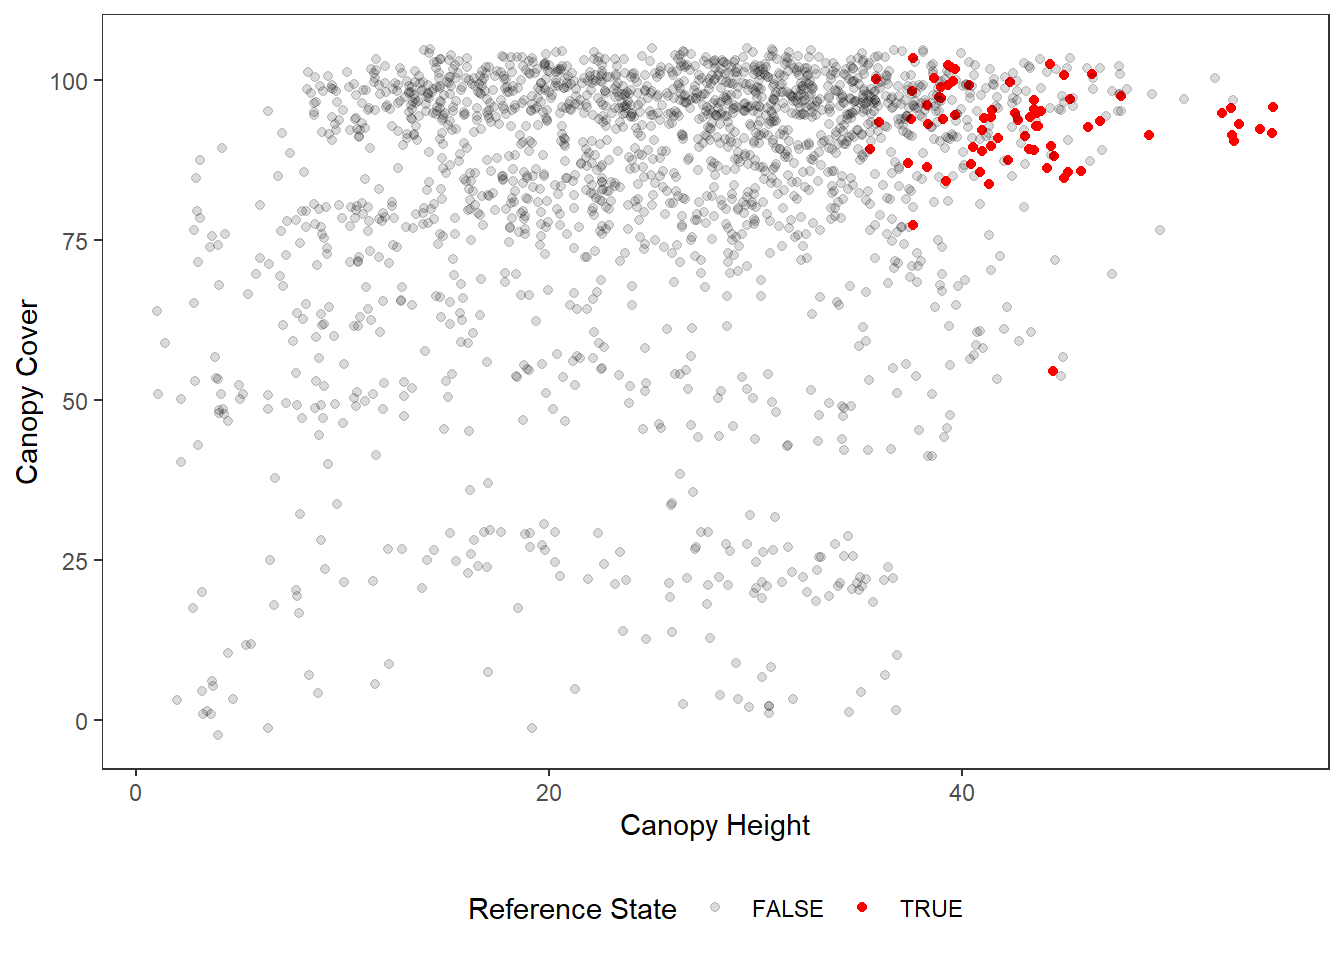

In [ ]:
subset <- str_pca %>%
  filter(strata == "4-3-3-4-2-1", forests == "coniferous") %>%
  mutate(q90 = elev_p95 >= quantile(elev_p95, 0.90),
         treat_q90 = q90 & pa == 1)

(
  notransform <- subset %>%
    #slice_sample(n = 10000) %>%
    ggplot(
      aes(x = elev_p95, y = percentage_first_returns_above_2m, col = treat_q90)
    ) +
    geom_jitter(height = 5, width = 5) +
    plot_theme +
    scale_colour_manual(values = c("#00000025", "red"), name = "Reference State") +
    labs(x = "Canopy Height", y = "Canopy Cover") +
    theme(legend.position = "bottom")
)